In [27]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import pypsa
import yaml

### Scenario selection

In [28]:
h2export = 200
EXPORT = h2export
CO2L = ""
CLUSTERS = 10
H = 3
LL = "3.0"
DISCOUNT_RATE = 0.071

### Settings

In [29]:


#RUN = "decr_13_3h_ws"
CATEGORY = "postnetworks"
#SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_{opts}_{H}H_2030_{DISCOUNT_RATE}_DF_{EXPORT}export"

#OVERRIDES = PATH + "pypsa-eur-sec/data/override_component_attrs"

PREFIX = "/mnt/c/Users/scl38887/Documents/git/pypsa-nz/"
#INPUT = PREFIX + f"workflow/subworkflows/pypsa-earth-sec/results/{RUN}/{CATEGORY}/{SCENARIO}.nc"

OUTPUT = PREFIX + "results/figures/comp/"

In [30]:
tech_colors = PREFIX + "config/tech_colors.yaml"

In [31]:
threshold_dispatch = 1e6 # 4 TWh
h2export = 200
opts = "Co2L"
SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_{opts}_{H}H_2030_{DISCOUNT_RATE}_AB_{h2export}export"


In [32]:
RUNS = {"0": "nz_nosmr",
        "20": "nz_nosmr",
        "200": "nz_nosmr",
        "400": "nz_nosmr",
       }

scenarios = ["0","20", "200", "400"]

### Data preparation

In [33]:
def load_config(config):
    with open(config, 'r') as stream:
        try:
            config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return config

### Dispatch data preparation

In [34]:
def get_dispatch(threshold_dispatch, ghrules, h2export, opts, show_demand=True):
    """Get dispatch
    """

    dispatch_all = pd.DataFrame()

    for sc in scenarios:

        SCENARIO = f"elec_s_{CLUSTERS}_ec_lc{LL}_{opts}_{H}H_2030_{DISCOUNT_RATE}_AB_{sc}export"
        INPUT = PREFIX + f"results/{RUNS[sc]}/{CATEGORY}/{SCENARIO}.nc"

        n = pypsa.Network(INPUT)

        dispatch = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") > 0]
        threshold_dispatch_sum = dispatch[dispatch < threshold_dispatch].sum()
        dispatch = dispatch[dispatch > threshold_dispatch]
        dispatch = pd.DataFrame(dispatch.droplevel(0)).T
        dispatch[f"(Dispatch < {threshold_dispatch/1e6} TWh thres.)"] = threshold_dispatch_sum

        dispatch.index = [sc]

        dispatch_all = pd.concat([dispatch_all, dispatch], axis=0) #, ignore_index=True)

    if show_demand == "bar":
        dispatch_demand = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") < 0]
        ely_electricity = dispatch_demand.droplevel(0).loc["H2 Electrolysis"].sum() * (-1)
        total_demand = dispatch_demand.sum() * (-1)
        other_demand = total_demand - ely_electricity
        dispatch_all.loc["Demand", "H2 Electrolysis electricity"] = ely_electricity
        dispatch_all.loc["Demand", "Domestic electricity"] = other_demand
        
    elif show_demand == "line":
        dispatch_demand = n.statistics.dispatch(bus_carrier="AC")[n.statistics.dispatch(bus_carrier="AC") < 0]
        ely_electricity = dispatch_demand.droplevel(0).loc["H2 Electrolysis"].sum() * (-1)
        total_demand = dispatch_demand.sum() * (-1)
        other_demand = total_demand - ely_electricity
        dispatch_all.loc[:, "H2 Electrolysis electricity"] = ely_electricity
        dispatch_all.loc[:, "Domestic electricity"] = other_demand
        
    
    return dispatch_all

In [35]:
dispatch = get_dispatch(threshold_dispatch, scenarios, h2export, opts, show_demand=False)

INFO:pypsa.io:Imported network elec_s_10_ec_lc3.0_Co2L_3H_2030_0.071_AB_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc3.0_Co2L_3H_2030_0.071_AB_20export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc3.0_Co2L_3H_2030_0.071_AB_200export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_10_ec_lc3.0_Co2L_3H_2030_0.071_AB_400export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [36]:
dispatch

carrier,Reservoir & Dam,Coal,Combined-Cycle Gas,Geothermal,Onshore Wind,Run of River,(Dispatch < 1.0 TWh thres.),Solar,Offshore Wind (AC),Offshore Wind (DC),Open-Cycle Gas,urban central solid biomass CHP CC
0,4.189823e+07,3.430158e+06,1.156002e+06,9.811085e+06,2.536277e+06,3.488059e+06,305615.961778,NaN,NaN,NaN,NaN,NaN
20,4.189764e+07,3.862922e+06,NaN,9.810860e+06,2.875264e+07,3.487532e+06,193448.792906,4.027503e+06,NaN,NaN,NaN,NaN
200,4.189786e+07,3.884871e+06,2.955226e+06,9.247022e+06,2.152334e+08,3.487633e+06,345156.997910,7.990710e+07,NaN,NaN,NaN,NaN
400,4.188161e+07,2.738473e+06,1.131312e+07,7.455808e+06,3.019581e+08,3.477833e+06,626943.154721,2.250937e+08,4.216533e+06,3.054221e+07,2.324942e+07,4.359012e+06


### Plot data

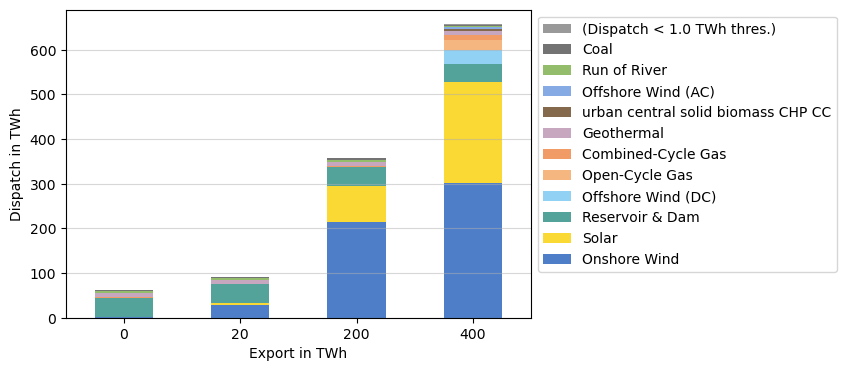

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

# Get colors from yaml defined in tech_colors
colors = load_config(tech_colors)["tech_colors"]

# Sort columns by highest value in first row
dispatch_sorted = dispatch[dispatch.iloc[-1].sort_values(ascending=False).index]
dispatch_twh = dispatch_sorted / 1e6 # convert to TWh

dispatch_twh.plot.bar(ax=ax, stacked=True, alpha=0.8, color=colors)

plt.xlabel("Export in TWh")
plt.ylabel("Dispatch in TWh")
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
#plt.ylim(0, 250)

plt.grid(axis='y', alpha=0.5) 

fig.savefig(OUTPUT+f"dispatch.pdf", bbox_inches="tight")
fig.savefig(OUTPUT+f"dispatch.png", bbox_inches="tight")